#  Week 7-  Quantum communications <a class="tocSkip">
    (c) Ariel Guerreiro 2023

Quantum communications is a rapidly advancing field at the intersection of quantum mechanics and information theory. The goal of quantum communication is to use the properties of quantum systems to transmit information securely and efficiently over long distances. This is accomplished by encoding information onto quantum states, which can then be transmitted through a quantum communication channel.

One of the most fascinating applications of quantum communication is quantum state teleportation, a protocol that allows a quantum state to be transmitted from one location to another without physically moving the particle carrying that state. This is achieved by using the entanglement between two quantum systems, known as quantum teleportation channels, to transfer the quantum state from one location to another.

Qiskit, a python-based open-source framework for quantum computing, provides a platform for experimenting with quantum state teleportation and other quantum communication protocols. In this exercise, we will use Qiskit to explore the basics of quantum teleportation and learn how it can be used to transmit quantum states securely and efficiently. By leveraging the power of Qiskit, we can gain an intuitive understanding of quantum communication and prepare for the exciting possibilities that this field holds for the future of information technology.

Throughout this notebook, we will use interactive examples and exercises to help you gain a deeper understanding of these topics.

# Before we start... <a class="tocSkip">
 
  Let us begin by runnning the initialization cell
    
$$
\def\ket#1{\left|#1\right\rangle }%
\def\bra#1{\left\langle #1\right|}%
\def\braket#1#2{\langle#1|#2\rangle}%
$$
   

In [23]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import random
import re             # regular expressions module

from pylab import plot
from qiskit import *
from qiskit.visualization import *

from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint

print("Imports Successful")


Imports Successful


# Teleportation 

Alice wants to send quantum information to Bob. Specifically, suppose she wants to transfer the state $|\psi\rangle =\alpha |0\rangle + \beta |1\rangle$  to Bob, which is assumed to be spatially separated. This is called state teleportation and its protocol can be decomposed in the following steps:

Step 1: Alice and Bob create an entangled state of two quantum registers. This is typically an element of the Bell basis, which for sake of simplicity we assume to be
\begin{align*}
\ket{\Phi^{+}} & :=\frac{1}{\sqrt{2}}\left(\ket{00}+\ket{11}\right)\\.
\end{align*}
One quantum register remains with Alice (say, the register $q_1$) and the other with Bob (say, the register $q_2$). 

Step 2: Alice applies a CNOT gate on  $q_1$  controlled by  $|\psi\rangle$ (the state she is trying to send Bob).

Step 3: Next, Alice applies a Hadamard gate to  $|\psi\rangle$;

Step 4: Alice applies a measurement to both her registers ( $q_1$  and $|\psi\rangle$).

Step 5: Then, Alice use a classical channel to communicate with Bob the results of the measurements (for example, via the phone). Note that this transfer of information is classical.

Step 6: Based on what Alice obtains form her measurements and tells Bob over the classical channel, he applies specific gates to his quantum register,  $q_2$. The gates to be applied are as follows :

00  →  Do nothing

01  →  Apply  $X$  gate

10  →  Apply  $Z$  gate

11  →  Apply  $ZX$  gate

where these gates correspond to the Pauli matrices
$$
X= \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}\ 
Y= \begin{pmatrix}
0 & -i \\
i & 0
\end{pmatrix}\ 
Z= \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
$$

As a result of this protocol the quantum state in Bob's register will be the state $|\psi\rangle$


The pair they create is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the Bell basis ( |+⟩  and  |−⟩ ) by using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the Bell basis.

In [24]:
# Simple function that applies a series of unitary gates from a given string

def Unitary(transformation_list, register, quantum_circuit, dagger):
    # transformation_list is a string of transformations to be applied to a register
    # register is the register where to apply the transformation
    # quantum_circuit is the circuit that contains the registers
    # dagger is 0 or 1 depending on whether we wand a transform or its H.c.
    functionmap = {
        #set of the possible transformation to be applied to the state
        
                    'x':quantum_circuit.x, #Pauli X
                    'y':quantum_circuit.y, #Pauli Y
                    'z':quantum_circuit.z, #Pauli Z
                    'h':quantum_circuit.h, #Hadamard                   
                    't':quantum_circuit.t, #T gate                   
    }
       #How to apply the Hermitc conjugate of the unitary transformation
    if dagger: 
        # Notice that only the T gate is not self-adjoint, 
        # hence is the only one that needs to be altered in the case of dagger ==1
        functionmap['t'] = quantum_circuit.tdg
    
    if dagger:
        # Applies the sequence of transforms in the case of dagger ==1 
        [functionmap[unitary](register) for unitary in transformation_list]
    else:
        # Applies the sequence of transforms in the case of dagger ==o (notice the reverse order)
        [functionmap[unitary](register) for unitary in transformation_list[::-1]]

<div class="alert alert-block alert-warning">
<b>Code Explained: </b>    

This code defines a function called "Unitary" that applies a series of unitary gates to a quantum register in a quantum circuit. The function takes in four arguments: the list of transformations to be applied, the register where the transformations are to be applied, the quantum circuit that contains the register, and a boolean variable called "dagger" that indicates whether the function should apply the transformation or its Hermitian conjugate.

The function starts by creating a dictionary called "functionmap" that maps the transformation characters to their corresponding functions in the quantum circuit library. The dictionary contains functions for the Pauli X, Y, and Z gates, the Hadamard gate, and the T gate. If "dagger" is set to 1, the dictionary maps the T gate to its Hermitian conjugate, which is denoted as "tdg".

If "dagger" is set to 1, the function applies the transformations in the order they are given in the list to the register. If "dagger" is set to 0, the function applies the transformations in the reverse order. The function uses list comprehension to iterate over the transformation list and apply each transformation to the register using the corresponding function from the "functionmap" dictionary.</div>

    
The registers used in the protocol are as follows:

$q[0]$: register containing the state to be teleported.

$q[1]$: Alice's second register, which will be entangled with Bob's

$q[2]$: Bob's register, which will be the destination for the teleportation


Beside these quantum register, the protocol also requires a classical register to contain the results from the measures

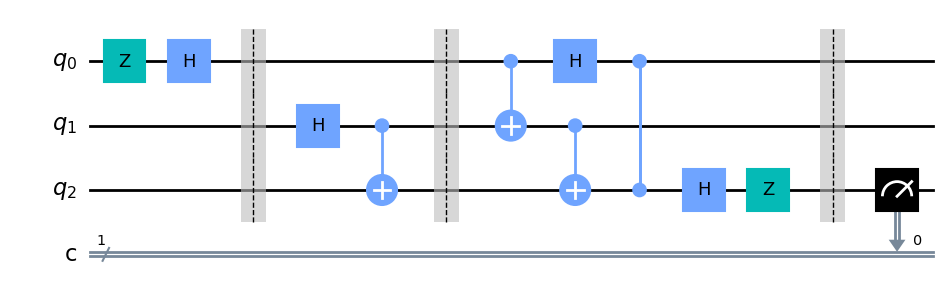

In [25]:
# Create the quantum circuit with 3 qubits and 1 classical bit
circuit5 = QuantumCircuit(3, 1)

#Generate a secret state for Alice using a series of unitary gates on a qubit  initialized in the state |0⟩ . 
secret = 'hz'
Unitary(secret, circuit5.qubits[0], circuit5, dagger = 0)
circuit5.barrier()

#Redy to start teleportation protocol....Beam me up Scotty! (STR)

# Step 1: Alice and Bob create an entangled state of two quantum registers. 
# Hadamard followed by CX generates the intended Bell state
circuit5.h(1)
circuit5.cx(1, 2)
circuit5.barrier()

#Step 2: Alice applies a CNOT gate on  q1  controlled by  q0
circuit5.cx(0, 1)

#Step 3: Alice applies a Hadamard gate to q0
circuit5.h(0)

#Step 4: Alice applies a measurement to both her registers
#step 5: Alice use a classical channel to communicate with Bob the results of the measurements
#Step 6: Bob applies specific gates to his quantum register q2. 

#All of these steps are done simultaneously,using these quantum operators
#Why are there no actual measurments but transformations applied to Bob 
#controled by the states in Alice registers?
circuit5.cx(1, 2)
circuit5.cz(0, 2)


#Let us verify if the teleportation s as worked by inverting the unitary 
#transformation that generateb the secret state in Alice's register  but 
#now applied to Bob's state. If everything went of it should reverse the 
#state back to |0>
Unitary(secret, circuit5.qubits[2], circuit5, dagger=1)

circuit5.barrier()
circuit5.measure(2, 0)

circuit5.draw(output='mpl')

<div class="alert alert-block alert-warning">
<b>Code Explained: </b>    

This code demonstrates a quantum state teleportation protocol using Qiskit. The code starts by creating a quantum circuit called "circuit5" with 3 qubits and 1 classical bit.

In the next step, a secret quantum state is generated for Alice using a series of unitary gates on a qubit initialized in the state |0⟩. The "Unitary" function is called with the secret state string and the first qubit in the circuit as arguments to apply the sequence of unitary gates. A barrier is added to the circuit to separate the initialization step from the teleportation protocol.

The teleportation protocol is implemented in the next steps. Alice and Bob create an entangled state of two quantum registers using a Hadamard gate followed by a CX gate on qubits 1 and 2. Alice applies a CNOT gate on q1 controlled by q0 and a Hadamard gate to q0. Alice then measures both of her qubits and communicates the measurement results to Bob using a classical channel. Bob applies specific gates to his quantum register q2 based on the measurement results he receives from Alice. These gates are chosen to "teleport" the quantum state of q0 to q2.

To verify if the teleportation was successful, the "Unitary" function is called again with the secret state string and the third qubit in the circuit as arguments, but with "dagger" set to 1 to apply the inverse transformations. The circuit then measures the third qubit and stores the result in the classical bit. 
    
In the next snippet, the circuit is run on a simulator backend and the measurement results are plotted using a histogram.

If the teleportation was successful, all of the measurement results should be in the state |0⟩, indicating that the secret state was successfully teleported from Alice's qubit to Bob's qubit.
    
</div>

{'0': 1024}


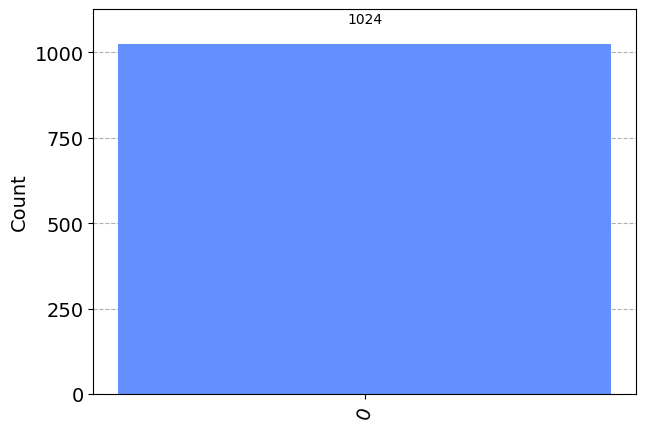

In [26]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circuit5, backend, shots=1024)
result = job.result()

measurement_result = result.get_counts(circuit5)
print(measurement_result)
plot_histogram(measurement_result) 
#perfect teleportation should provide all the counts in the state |0>

**Exercises**

1. Verify whether this protocol works for a wide range of secret states.
    
2. Test the protocol in the IBM computer a measure the fidelity for several states.
    
    <div class="alert alert-block alert-info"><b>Question 1:</b> Does the fidelity changes if have a more complex unitary transformation to generate the secret state? Why?</div>
    
    <div class="alert alert-block alert-info"><b>Question 2:</b> Does the fidelity depends on the position of of the secret state in the Bloch sphere? If so, why?</div>

3. Alter the previous code to describe quantum state teleportation in a noisy channel.

    <div class="alert alert-block alert-info"><b>Question 3:</b> How does the noise alter the fidelity between the input and output state?
</div>

4. Compute the channel capacity in function of the noise level.



### Advanced exercises <a class="tocSkip">
    
5. Alter this protocol to teleport a 2-qubit state.
    
6. Alter this protocol to teleport a 1-qubit mixed state.
    
    <div class="alert alert-block alert-info"><b>Question 4:</b> Does the initial entropy influences the fidelity of the teleportation?
</div>

# Quantum Key Distribution

(adapted from: https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html)

When Alice and Bob need to send secret messages, they must encrypt the message to ensure its confidentiality. One approach to achieve that is to use symmetric-key cryptography, which requires Alice and Bob to share a secret key.

However, if Alice and Bob want to share their secret key using a classical communication channel controlled by Eve, they have to trust that Eve will not copy the key. In contrast, if Alice and Bob use a quantum communication channel, which utilizes individual photons to represent a qubit, they can detect if Eve tries to read Bob's message before it reaches Alice. In this channel, the polarization of photons can be in one of two states.

The protocol exploits the fundamental principle of quantum mechanics that measuring a qubit can change its state. If Alice sends Bob a qubit and Eve attempts to measure it before Bob, there is a possibility that Eve's measurement will change the qubit's state, and Bob will receive a different state than Alice sent. In this case, Bob now has a 50% chance of measuring 1, which signals to him and Alice that there is something wrong with their channel.

To guarantee that an eavesdropper has a negligible chance of intercepting the key, the quantum key distribution protocol repeats this process multiple times.

## Protocol Overview  

The protocol makes use of the fact that measuring a qubit can change its state. If Alice sends Bob a qubit, and an eavesdropper (Eve) tries to measure it before Bob does, there is a chance that Eve’s measurement will change the state of the qubit and Bob will not receive the qubit state Alice sent.  

If Alice prepares a qubit in the state $|+\rangle$ (`0` in the $X$-basis), and Bob measures it in the $X$-basis, Bob is sure to measure `0`:

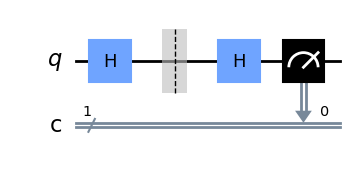

In [27]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)
qc.draw(output='mpl')

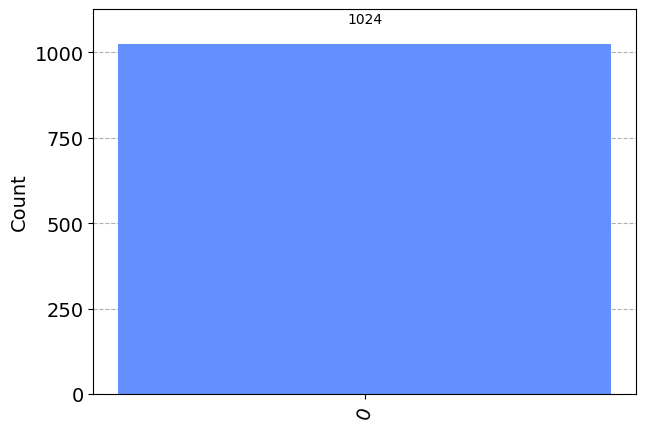

In [28]:
# Simulate circuit
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc, shots=1024)
plot_histogram(job.result().get_counts())

But if Eve tries to measure this qubit in the $Z$-basis before it reaches Bob, she will change the qubit's state from $|+\rangle$ to either $|0\rangle$ or $|1\rangle$, and Bob is no longer certain to measure `0`:

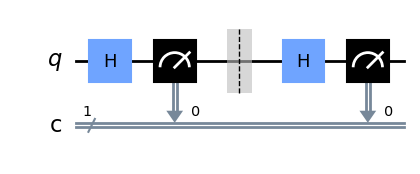

In [29]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

qc.draw(output='mpl')

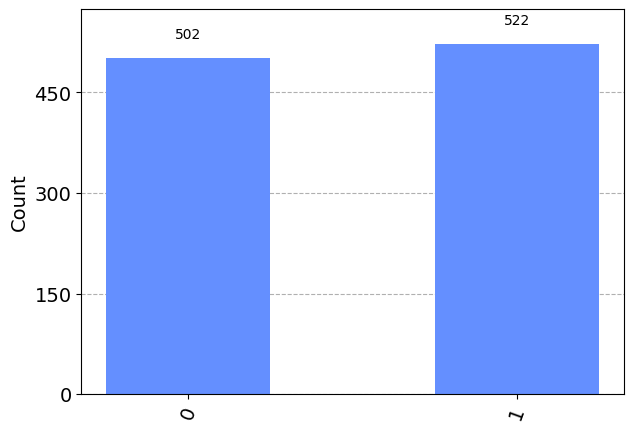

In [30]:
# Simulate circuit
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())

We can see here that Bob now has a 50% chance of measuring `1`, and if he does, he and Alice will know there is something wrong with their channel.

The quantum key distribution protocol involves repeating this process enough times that an eavesdropper has a negligible chance of getting away with this interception. It is roughly as follows:

**- Step 1**

Alice chooses a string of random bits, e.g.:

`1000101011010100`

And a random choice of basis for each bit:

`ZZXZXXXZXZXXXXXX`

Alice keeps these two pieces of information private to herself. 

**- Step 2**

Alice then encodes each bit onto a string of qubits using the basis she chose; this means each qubit is in one of the states $|0\rangle$, $|1\rangle$, $|+\rangle$ or $|-\rangle$, chosen at random. In this case, the string of qubits would look like this:

$$ |1\rangle|0\rangle|+\rangle|0\rangle|-\rangle|+\rangle|-\rangle|0\rangle|-\rangle|1\rangle|+\rangle|-\rangle|+\rangle|-\rangle|+\rangle|+\rangle
$$

This is the message she sends to Bob.

**- Step 3**

Bob then measures each qubit at random, for example, he might use the bases:

`XZZZXZXZXZXZZZXZ`

And Bob keeps the measurement results private.

**- Step 4**

Bob and Alice then publicly share which basis they used for each qubit. If Bob measured a qubit in the same basis Alice prepared it in, they use this to form part of their shared secret key, otherwise they discard the information for that bit.

**- Step 5**

Finally, Bob and Alice share a random sample of their keys, and if the samples match, they can be sure (to a small margin of error) that their transmission is successful.


## Running the QKD protocol: Without Interception

Let’s first see how the protocol works when no one is listening in, then we can see how Alice and Bob are able to detect an eavesdropper. 

**- Step 1**

Alice generates her random set of bits:

In [31]:
np.random.seed(seed=0)
n = 100
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


To generate pseudo-random keys, we will use the `randint` function from numpy. To make sure you can reproduce the results on this page, we will set the seed to 0. In this example, Alice will send a message 100 qubits long.

At the moment, the set of bits '`alice_bits`' is only known to Alice. We will keep track of what information is only known to Alice, what information is only known to Bob, and what has been sent over Eve's channel in a table like this:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |       &nbsp;    |

**- Step 2**

Alice chooses to encode each bit on qubit in the $X$ or $Z$-basis at random, and stores the choice for each qubit in `alice_bases`. In this case, a `0` means "prepare in the $Z$-basis", and a `1` means "prepare in the $X$-basis":

In [32]:
np.random.seed(seed=0)
n = 100
## Step 1
#Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(alice_bases)

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


Alice also keeps this knowledge private:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |     &nbsp;      |

The function `encode_message` below, creates a list of `QuantumCircuit`s, each representing a single qubit in Alice's message:

In [33]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message
    
    
    np.random.seed(seed=0)

    
    
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

We can see that the first bit in `alices_bits` is `0`, and the basis she encodes this in is the $X$-basis (represented by `1`):

In [34]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

bit = 1
basis = 1


And if we view the first circuit in `message` (representing the first qubit in Alice's message), we can verify that Alice has prepared a qubit in the state $|+\rangle$:

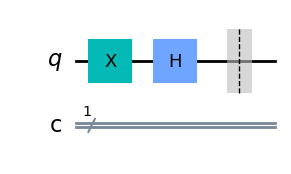

In [35]:
message[0].draw(output='mpl')

As another example, we can see that the fourth bit in `alice_bits` is `1`, and it is encoded in the $Z$-basis, Alice prepares the corresponding qubit in the state $|1\rangle$:

bit = 0
basis = 0


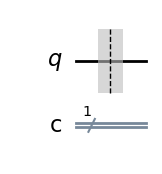

In [36]:
print('bit = %i' % alice_bits[4])
print('basis = %i' % alice_bases[4])
message[4].draw(output='mpl')

This message of qubits is then sent to Bob over Eve's quantum channel:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |

**- Step 3**

Bob then measures each qubit in the $X$ or $Z$-basis at random and stores this information:

In [37]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

[1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1]


`bob_bases` stores Bob's choice for which basis he measures each qubit in.

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |
|                   |                  |    bob_bases    |

Below, the function `measure_message` applies the corresponding measurement and simulates the result of measuring each qubit. We store the measurement results in `bob_results`.

In [38]:
def measure_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        result = backend.run(message[q], shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements


np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)


We can see that the circuit in message[0] (representing the 0th qubit) has had an  𝑋
 -measurement added to it by Bob. Since Bob has by chance chosen to measure in the same basis Alice encoded the qubit in, Bob is guaranteed to get the result `0`. For the 6th qubit (shown below), Bob's random choice of measurement is not the same as Alice's, and Bob's result has only a 50% chance of matching Alices'. 

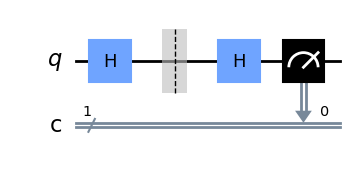

In [39]:
message[0].draw(output='mpl')

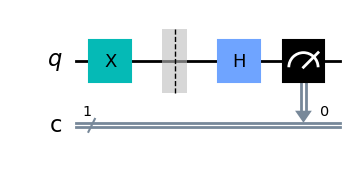

In [40]:
message[6].draw(output='mpl')

In [41]:
print(bob_results)

[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]


Bob keeps his results private.

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |

**- Step 4**

After this, Alice reveals (through Eve's channel) which qubits were encoded in which basis: 

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |

And Bob reveals which basis he measured each qubit in:

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |      &nbsp;     |

If Bob happened to measure a bit in the same basis Alice prepared it in, this means the entry in `bob_results` will match the corresponding entry in `alice_bits`, and they can use that bit as part of their key. If they measured in different bases, Bob's result is random, and they both throw that entry away. Here is a function `remove_garbage` that does this for us:

In [42]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits
    
    
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(alice_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


Alice and Bob both discard the useless bits, and use the remaining bits to form their secret keys.

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     &nbsp;      |

In [43]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |




**- Step 5**

Finally, Bob and Alice compare a random selection of the bits in their keys to make sure the protocol has worked correctly:

In [44]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample
    
    
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Alice and Bob both broadcast these publicly, and remove them from their keys as they are no longer secret.

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |


If the protocol has worked correctly without interference, their samples should match.

If their samples match, it means (with high probability) `alice_key == bob_key`. They now share a secret key they can use to encrypt their messages!

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |
|     shared_key    |                    |    shared_key   |

In [45]:
bob_sample == alice_sample

True

In [46]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
key length = 33


## Running the QKD protocol: With Interception
Let’s now see how Alice and Bob can tell if Eve has been trying to listen in on their quantum message. We repeat the same steps as without interference, but before Bob receives his qubits, Eve will try and extract some information from them. Let's set a different seed so we get a specific set of reproducible 'random' results.

**- Step 1**

Alice generates her set of random bits:

In [47]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
print(alice_bits)

[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1]


**- Step 2**

Alice encodes these in the $Z$ and $X$-bases at random, and sends these to Bob through Eve's quantum channel:

In [48]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(alice_bases)

[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1]


In this case, the first qubit in Alice's message is in the state $|+\rangle$:

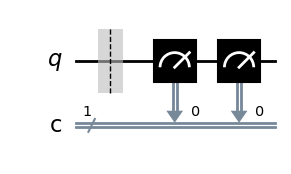

In [56]:
message[0].draw(output='mpl')

### Interception!

Suddenly, Eve intercepts the message as it passes through her channel. She tries to measure the qubits in a random selection of bases, in the same way Bob will later.

In [50]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
print(intercepted_message)

[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


We can see the case of qubit 0 below; Eve's random choice of basis is not the same as Alice's, and this will change the qubit state from $|+\rangle$, to a random state in the $Z$-basis, with 50% probability of $|0\rangle$ or $|1\rangle$:

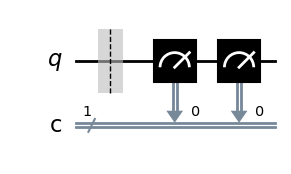

In [57]:
message[0].draw(output='mpl')

**- Step 3**

Eve then passes on the qubits to Bob, who measures them at random. In this case, Bob chose (by chance) to measure in the same basis Alice prepared the qubit in. Without interception, Bob would be guaranteed to measure `0`, but because Eve tried to read the message he now has a 50% chance of measuring `1` instead.

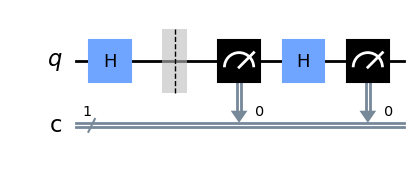

In [58]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
message[0].draw(output='mpl')

**- Step 4**

Bob and Alice reveal their basis choices, and discard the useless bits:

In [53]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

**- Step 5**

Bob and Alice compare the same random selection of their keys to see if the qubits were intercepted:

In [54]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [59]:
bob_sample == alice_sample

False

Oh no! Bob's key and Alice's key do not match. We know this is because Eve tried to read the message between steps 2 and 3, and changed the qubits' states. For all Alice and Bob know, this could be due to noise in the channel, but either way they must throw away all their results and try again- Eve's interception attempt has failed.

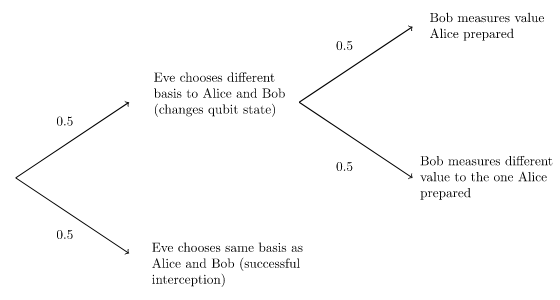

## Risk Analysis

For this type of interception, in which Eve measures all the qubits, there is a small chance that Bob and Alice's samples could match, and Alice sends her vulnerable message through Eve's channel. Let's calculate that chance and see how risky quantum key distribution is.

- For Alice and Bob to use a qubit's result, they must both have chosen the same basis. If Eve chooses this basis too, she will successfully intercept this bit without introducing any error. There is a 50% chance of this happening.
- If Eve chooses the *wrong* basis, i.e. a different basis to Alice and Bob, there is still a 50% chance Bob will measure the value Alice was trying to send. In this case, the interception also goes undetected.
- But if Eve chooses the *wrong* basis, i.e. a different basis to Alice and Bob, there is a 50% chance Bob will not measure the value Alice was trying to send, and this *will* introduce an error into their keys.


If Alice and Bob compare 1 bit from their keys, the probability the bits will match is $0.75$, and if so they will not notice Eve's interception. If they measure 2 bits, there is a $0.75^2 = 0.5625$ chance of the interception not being noticed. We can see that the probability of Eve going undetected can be calculated from the number of bits ($x$) Alice and Bob chose to compare:

$$ P(\text{undetected}) = 0.75^x $$

If we decide to compare 15 bits as we did above, there is a 1.3% chance Eve will be undetected. If this is too risky for us, we could compare 50 bits instead, and have a 0.00006% chance of being spied upon unknowingly.

You can retry the protocol again by running the cell below. Try changing `sample_size` to something low and see how easy it is for Eve to intercept Alice and Bob's keys.

In [55]:
n = 100
# Step 1
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
# Step 2
message = encode_message(alice_bits, alice_bases)
# Interception!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
# Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
# Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
# Step 5
sample_size = 15 # Change this to something lower and see if 
                 # Eve can intercept the message without Alice
                 # and Bob finding out
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve went undetected!")

Eve's interference was detected.


**Exercises**

5. Test the QKD protocol with a noise model.

    <div class="alert alert-block alert-info"><b>Question 4:</b> Is it possible to distinguish noise from evesdropping? If so, how?</div>


<div class="alert alert-success">
<b>Today's afterthoughts:</b>

What has changed, if anything, in your perspective about quantum measurements after this notebook?
</div>